In [1]:
import pandas as pd
import numpy as np

from scipy.fft import fft, fftfreq, ifft, fft2, ifft2, ifftshift
from scipy.signal import blackman
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.signal import butter
from scipy import signal
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
from scipy.ndimage import gaussian_filter as gf

from xrdc import featurization as feat
from xrdc import fourier
from xrdc.datasets import d3d


#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [2]:
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc.datasets import d3d

from xrdc import peak_fitting as pf

from importlib import reload
reload(feat)

workflows/alanConfig


<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [3]:
def annotate():
    plt.xlabel('$q~(1 / A)$')
    plt.ylabel('sample index')

imargs = {'cmap': 'jet', 'aspect': 8}
aspect = 8

def heatmap(fig, arr, label = '', **kwargs):
    ax = fig

    stride = 100
    qticks = d3d.q[::stride]
    labels = ['{:0.1f}'.format(elt) for elt in qticks]
    
    ax.set_xticklabels(labels);
    ax.set_xticks(np.arange(len(qticks)) * stride);
    if kwargs is not None:
        (kwargs.update(imargs))
    else:
        kwargs = imargs
    plt.imshow(arr, **kwargs)
    plt.title(label)
    annotate()
    
def norm(arr):
    return arr / arr.mean()

In [4]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = (patterns.values.T)[:, 1:]

for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
background_extra, _, _, _ = sep.separate_signal(patterns, background_after_filter = False,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6)

# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()[7, :, :]
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

tmp = np.zeros_like(patterns)
tmp[:patterns.shape[0], :background_extra.shape[1]] = background_extra[:patterns.shape[0], :]
tmp = sep.CTinterpolation(tmp)

tmp *= (patterns.mean() / tmp.mean())

patterns = patterns + 2 * tmp

from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6,
                                                    smooth_neighbor_background = 1)

import matplotlib
plt.rcParams["figure.figsize"]=(12, 12)
matplotlib.rcParams["figure.figsize"]=(12, 12)

%matplotlib inline
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

(0, 0)
(0, 0)


Calculate heatmap for visualization of peak shift correction

numBlocks: 78, dataPts/Block: 10.256410256410257
[  0. 105. 144. 246. 252. 318. 374. 430. 466. 581. 629. 672. 799.]
False
Experimental Info used: 

{'blockBounds': array([  0., 105., 144., 246., 252., 318., 374., 430., 466., 581., 629.,
       672., 799.])}
Peak at 68, start iteration with error = 0.10463437140455069
Peak at 68, iteration 0: error = 0.03163643951371987
0.12820298546119024
    ----Saving data for block between 1.00 - 104.00
[67.79886890120319, -0.0014749778773370385, 55.760546625121954, 1.4912447145319128, 0.6663004534157789]
Peak at 125, start iteration with error = 0.3849277945244749
Peak at 125, iteration 0: error = 0.30379805473288507
1.0669013199622195
    ----Saving data for block between 105.00 - 143.00
[125.03331663594487, 0.12777228524559747, 65.05949037986211, 2.1662633711746286e-14, 2.568380752905859]
Peak at 151, start iteration with error = 0.08833628741609012
Peak at 151, iteration 0: error = 0.03946742464568859
0.3677919149083769
    ----Saving data for b

Peak at 125, start iteration with error = 0.14352780842815588
Peak at 125, iteration 0: error = 0.1268248778095841
4.034829030977604
Peak at 125, iteration 1: error = 0.11031792619716377
3.5735627189746135
Peak at 125, iteration 2: error = 0.08306650392532464
    ----Saving data for block between 105.00 - 252.00
[124.84767433518081, 3.0489604987158847, 44.07597333498008, 1.6677589633757988, 0.5703099209782427, 129.21142164973844, -2.406749100168915, 17.08487678551755, 0.0002419399687020481, 2.298405732808532, 146.7260280955994, -0.5869193575189944, 4.124282038772306, 1.843395814951403, 1.0087110369011638e-17]
Peak at 301, start iteration with error = 0.3112607536637593
Peak at 301, iteration 0: error = 0.07002750034807412
0.6384585965579028
    ----Saving data for block between 253.00 - 315.00
[301.05352897460364, -0.09533859231371618, 222.88265481717207, 1.8061695488861842, 1.2994364525439515]
Peak at 320, start iteration with error = 0.12560855480877242
Peak at 320, iteration 0: erro

Peak at 301, start iteration with error = 0.25026706712691743
Peak at 301, iteration 0: error = 0.08249612628495549
0.8736469871284307
    ----Saving data for block between 245.00 - 374.00
[300.75084878709856, -0.05626482953806484, 302.7622199853481, 1.3767626577687835, 2.362464165878994]
Peak at 405, start iteration with error = 0.2392612592710511
Peak at 405, iteration 0: error = 0.03410749215145916
0.8631404059716863
    ----Saving data for block between 375.00 - 429.00
[404.7805513500204, -0.03565519004022147, 48.068933161549396, 2.509635936022979, 1.6779610082460918]
Peak at 436, start iteration with error = 0.20892089824362417
Peak at 436, iteration 0: error = 0.009363061482793218
0.3888411926161357
    ----Saving data for block between 430.00 - 458.00
[435.67338527585576, -0.016209501577170014, 13.594636117370948, 2.729427095540269, 1.4615503035316868]
Peak at 551, start iteration with error = 0.11223265865015863
Peak at 551, iteration 0: error = 0.032828598958470095
1.486703185

    ----Saving data for block between 229.00 - 371.00
[300.8261240376777, -6.190134900316133, 175.19472490021255, 2.493321629607528, 1.0249217829574813, 289.68011843353827, 10.720799814450837, 106.37336977501974, 7.470120720541237, 2.081946107970207e-34, 226.60414103460144, -4.582940202273213, 2.8699311921844695, 22.54879449419223, 1.536519774340364e-05]
Peak at 405, start iteration with error = 0.1853007516235964
Peak at 405, iteration 0: error = 0.04406353943209813
0.9110309019272324
    ----Saving data for block between 372.00 - 429.00
[404.49500967150465, -0.01825822986167817, 33.88594742083187, 3.0242058313301756, 1.123462064586689]
Peak at 436, start iteration with error = 0.11909802878209597
Peak at 436, iteration 0: error = 0.01178247039056773
0.3891126482694391
    ----Saving data for block between 430.00 - 466.00
[435.820772552106, -0.0032025093121885277, 7.772675227179992, 3.5173344693844255, 5.077067378995329e-15]
Peak at 551, start iteration with error = 0.1376791988706784

    ----Saving data for block between 615.00 - 798.00
[738.7552574586701, 1.5524796656126973, 46.13322747220778, 7.13159446278882, 1.7761998428182628e-20, 717.079739485218, -0.9040389360386301, 89.0329382405247, 13.398910630819381, 2.7520460467351476e-25, 623.8008483405325, -0.6218732992574876, 6.710404600723785, 2.909230882519227, 3.10615551191387]
numBlocks: 46, dataPts/Block: 17.391304347826086
[  0. 154. 369. 466. 616. 799.]
False
Experimental Info used: 

{'blockBounds': array([  0., 154., 369., 466., 616., 799.])}
Peak at 66, start iteration with error = 0.16442012852573065
Peak at 66, iteration 0: error = 0.14116943324462178
7.47201714455891
Peak at 66, iteration 1: error = 0.05595538083152848
2.7953683226577346
Peak at 66, iteration 2: error = 0.03872059071053775
    ----Saving data for block between 1.00 - 153.00
[66.23058401512363, -1.1218025849375646, 41.925376813161144, 2.845889427038619, 1.4976585941376817, 123.22105975929587, 1.8609348813833915, 19.04519529610798, 1.33989

Peak at 712, iteration 0: error = 0.045589622854374776
0.8362585797218864
    ----Saving data for block between 657.00 - 798.00
[712.2545284981028, -0.08171514369058926, 143.44089297743244, 7.059860585224445, 5.419685405345983]
numBlocks: 59, dataPts/Block: 13.559322033898304
[  0. 150. 365. 457. 559. 799.]
False
Experimental Info used: 

{'blockBounds': array([  0., 150., 365., 457., 559., 799.])}
Peak at 59, start iteration with error = 0.09787585804788658
Peak at 59, iteration 0: error = 0.0831265486575549
4.830804891840054
Peak at 59, iteration 1: error = 0.03613516991641622
1.514330693728434
    ----Saving data for block between 1.00 - 149.00
[60.37126057331585, 0.0729185005964413, 11.500107910702248, 5.535786287145442, 1.8720046289254012e-08, 110.75879275668288, -0.06849752658400804, 10.45141569317734, 2.011190462907197e-06, 4.025632988761219]
Peak at 284, start iteration with error = 0.15966219317093822
Peak at 284, iteration 0: error = 0.0829469715236235
1.442949721416488
    -

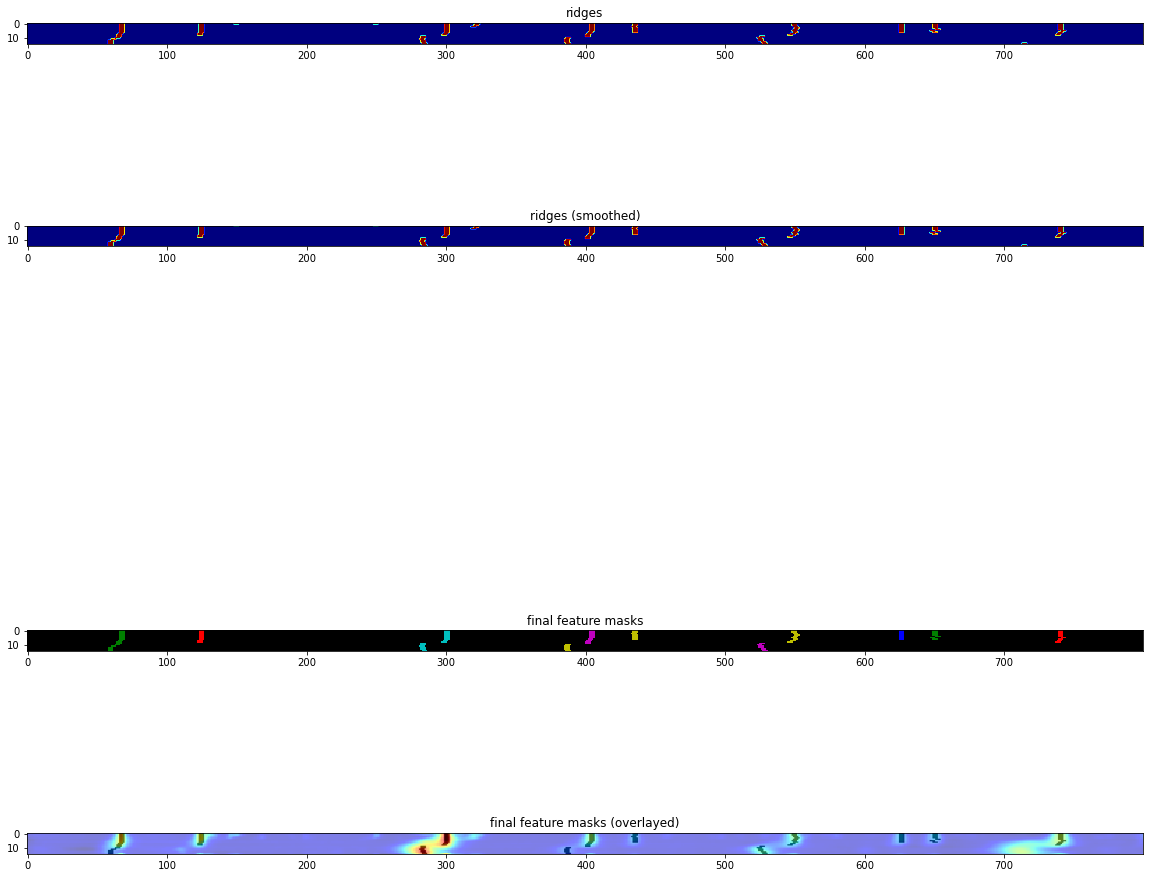

In [6]:
fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
                   background = background, bg_shift_pos = False)



Peak at 300, start iteration with error = 0.2311539982654663
Peak at 300, iteration 0: error = 0.2045356016959264
Peak at 283, start iteration with error = 0.3088657802074631
Peak at 283, iteration 0: error = 0.2299398197891481
using fitlists
using fitlists
12
3.296105557383848


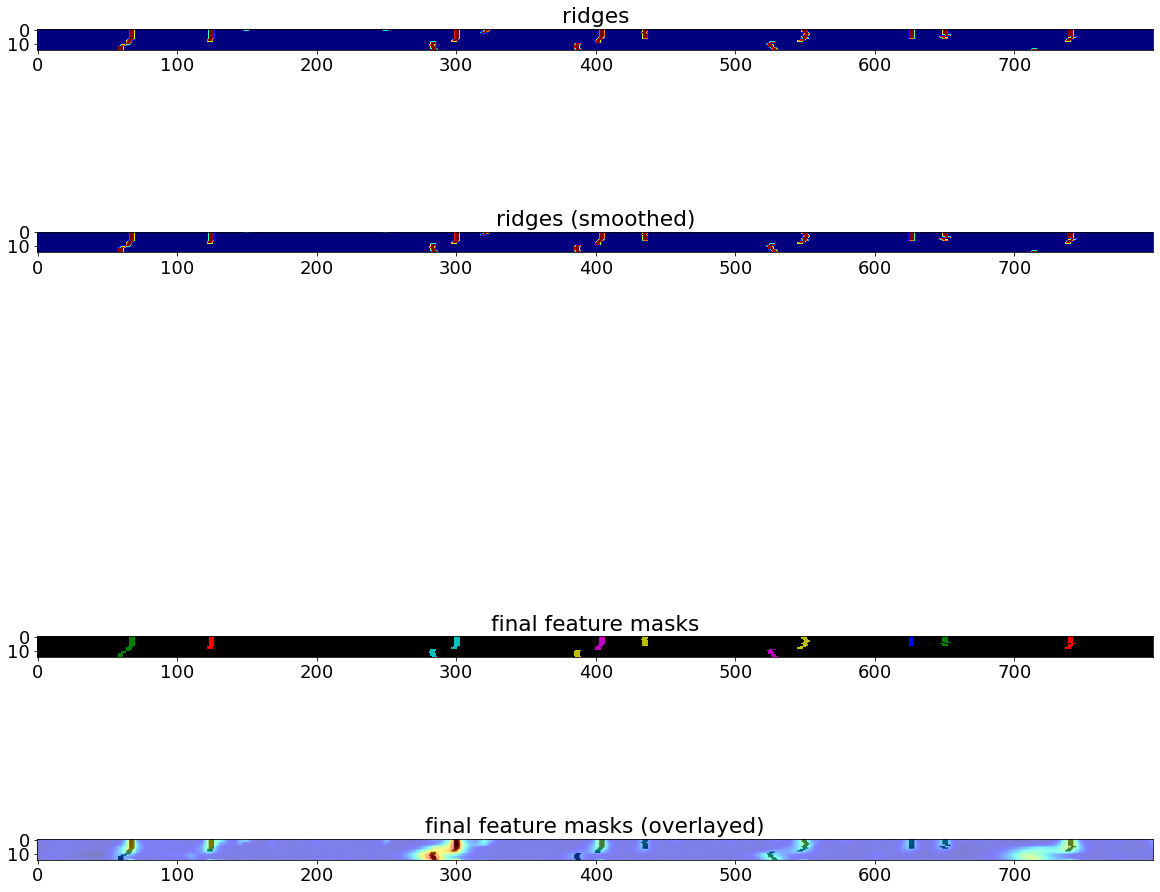

In [11]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 3)

straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns, activations, labeled)

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


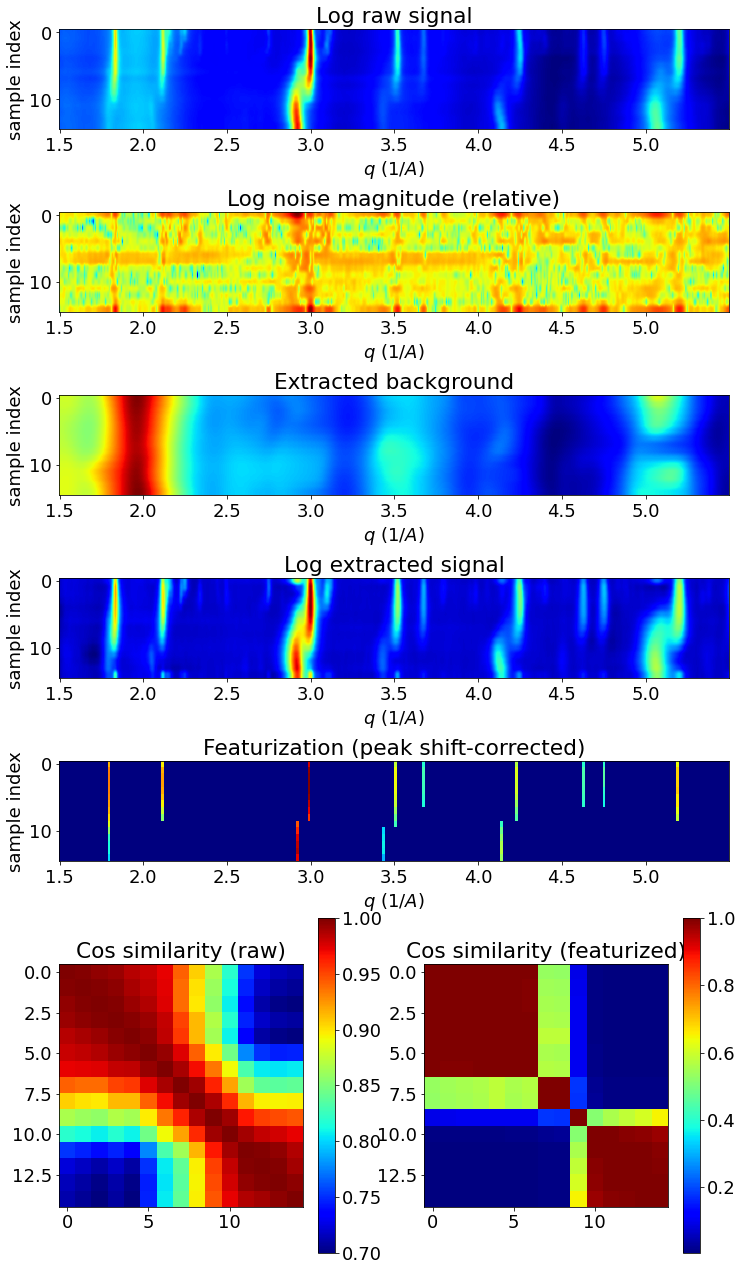

In [8]:
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(12, 23), constrained_layout=False)
spec = fig.add_gridspec(7, 2)

imargs = {'cmap': 'jet', 'aspect': 8}

ax0 = fig.add_subplot(spec[0, :])
heatmap(ax0, np.log(1 + norm(patterns)), label = 'Log raw signal')
# annotate_axes(ax0, 'ax0')

ax1 = fig.add_subplot(spec[1, :])
heatmap(ax1, np.log10(np.abs(fast_T / patterns) ), "Log noise magnitude (relative)")
#annotate_axes(ax10, 'ax10')


ax2 = fig.add_subplot(spec[2, :])
heatmap(ax2, background, 'Extracted background')
# plt.title("Log signal")

ax3 = fig.add_subplot(spec[3, :])
#heatmap(ax3, np.log(1 + norm(fast_q - fast_q.min())))
heatmap(ax3, np.log(1 + norm((slow_T - background) - (slow_T - background).min())), "Log extracted signal")
# annotate_axes(ax11, 'ax11')

ax4 = fig.add_subplot(spec[4, :])
heatmap(ax4, np.log(1 + straightened_heatmap), interpolation = 'none',
        label = 'Featurization (peak shift-corrected)')

imargs = {'cmap': 'jet', 'aspect': 1}

ax50 = fig.add_subplot(spec[5:7, 0])
img = ax50.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
plt.colorbar(img, ax = ax50)

ax51 = fig.add_subplot(spec[5:7, 1])
img = ax51.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.title('Cos similarity (featurized)')
plt.colorbar(img, ax = ax51)

# fig.suptitle('Manually added subplots, spanning a column')

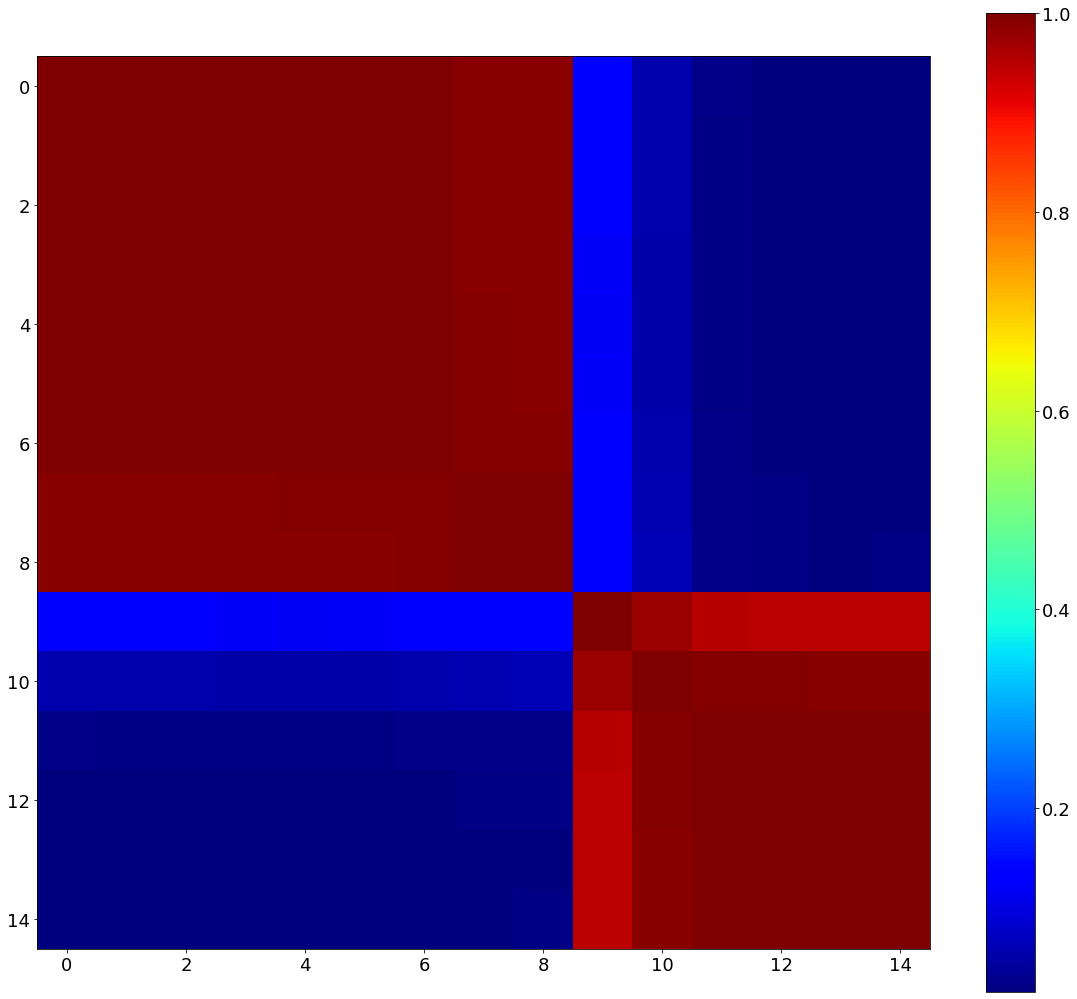

In [9]:
plt.imshow(feat.csim_pairs(activations.T), cmap = 'jet')
plt.colorbar()

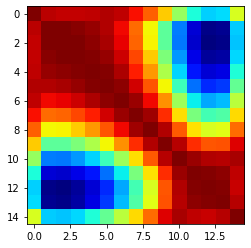

In [418]:
plt.imshow(feat.csim_pairs(((slow_T - background) - (slow_T - background).min())), cmap = 'jet')

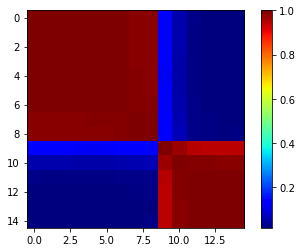

In [431]:
plt.imshow(feat.csim_pairs(activations.T), cmap = 'jet')
plt.colorbar()

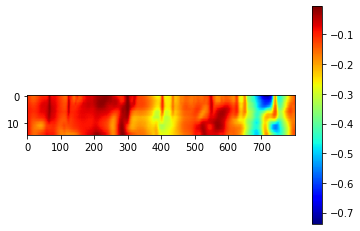

In [364]:
plt.imshow((2 * tmp - background) / patterns, cmap = 'jet', aspect = aspect)
plt.colorbar()

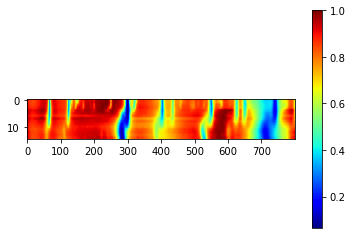

In [365]:
plt.imshow((2 * tmp) / patterns, cmap = 'jet', aspect = aspect)
plt.colorbar()

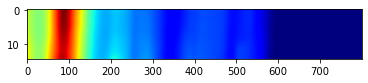

In [366]:
plt.imshow(tmp, cmap = 'jet', aspect = aspect)

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


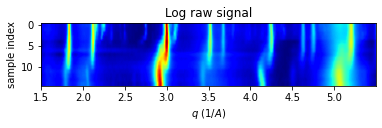

In [119]:
fig, ax = plt.subplots(1,1)
heatmap(fig, ax)

In [ ]:
plt.imshow(slow_q, cmap = 'jet')
plt.title("Interpolated background")
annotate()